<a href="https://colab.research.google.com/github/octavio-santiago/anomaly_detection/blob/master/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as  web
import seaborn as sns
import math
import datetime as dt
from sklearn import preprocessing

In [0]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn import svm

In [0]:
df = pd.read_excel("/gdrive/My Drive/20200415 O&G Equipment Data.xlsx")

Calculate how many fails

In [0]:
print("Fails: ", len(df[df['Fail'] ==  True]), ' ', len(df[df['Fail'] ==  True])/len(df) * 100 , ' %' )

Fails:  66   8.25  %


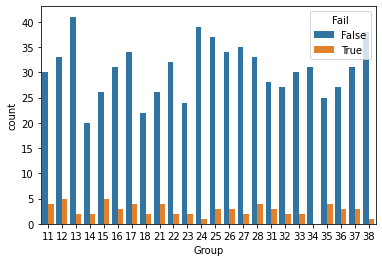

In [0]:
fig, ax = plt.subplots()
ax = sns.countplot(x="Group", hue="Fail", data=df)

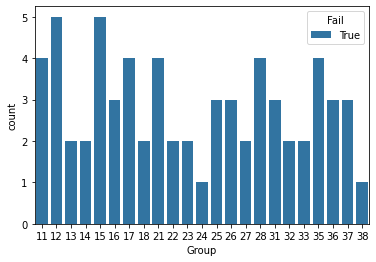

In [0]:
fig, ax = plt.subplots()
ax = sns.countplot(x="Group", hue="Fail", data=df[df['Fail'] == True])

Clustering

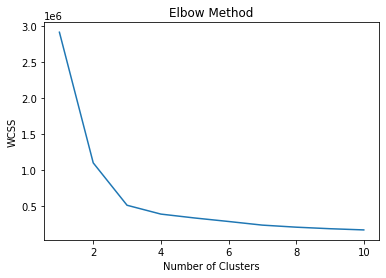

In [0]:
X = df[df['Fail'] == True]
wcss = []
for i in range(1,11):
  km = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
  km.fit(X)
  wcss.append(km.inertia_)

fig, ax = plt.subplots()
ax = plt.plot(range(1,11),wcss)
ax = plt.title('Elbow Method')
ax = plt.xlabel('Number of Clusters')
ax = plt.ylabel('WCSS')

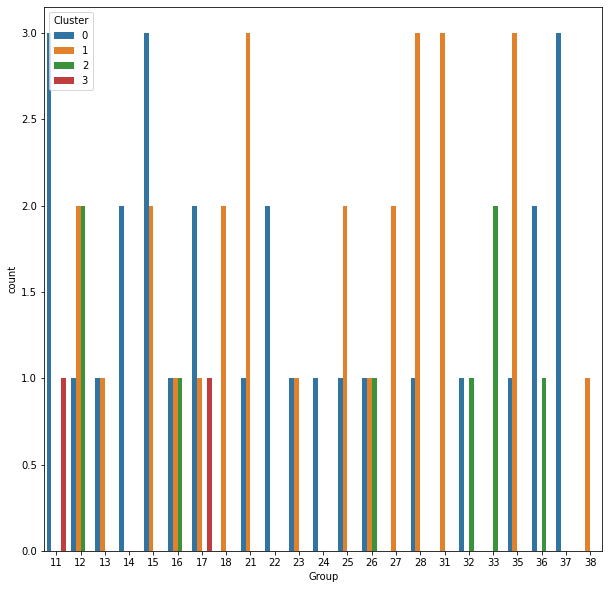

In [0]:
X = X.drop(['Fail','Cycle','Preset_1','Preset_2'],axis=1)
k = 4
kmeans = KMeans(n_clusters=k,init='k-means++')
kmeans.fit(X)
#coluna = variavel + "_cluster"
X['Cluster'] = kmeans.predict(X)

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.countplot(x="Group", hue="Cluster", data=X)


In [0]:
X.groupby('Cluster').describe()

Group                        ...   Frequency                        
        count       mean        std  ...         50%         75%         max
Cluster                              ...                                    
0        26.0  23.384615   9.130507  ...   94.577417  107.027335  141.502855
1         7.0  23.857143  10.367072  ...   50.456673   93.459641  111.281635
2        31.0  23.193548   8.010074  ...  100.598048  110.692304  178.090303
3         2.0  14.000000   4.242641  ...  150.027241  150.293015  150.558790

[4 rows x 56 columns]

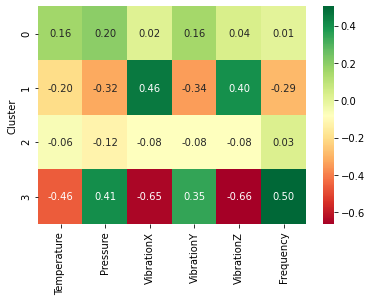

In [0]:
cluster_avg = X[['Cluster','Temperature','Pressure','VibrationX','VibrationY','VibrationZ','Frequency']].groupby('Cluster').mean()
population_avg = X[['Temperature','Pressure','VibrationX','VibrationY','VibrationZ','Frequency']].mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)
sns.heatmap(data=relative_imp,annot=True,fmt='.2f',cmap='RdYlGn')

In [0]:
df2 = df.copy()
df2['Fail'] = df2['Fail'].astype('category')
df2['Fail'] = df2['Fail'].cat.codes

df2['Last_Fail'] = df2['Last_Fail'].astype('category')
df2['Last_Fail'] = df2['Last_Fail'].cat.codes

pd.plotting.scatter_matrix(df2, figsize=(20, 20))
plt.show()

Anomaly detection

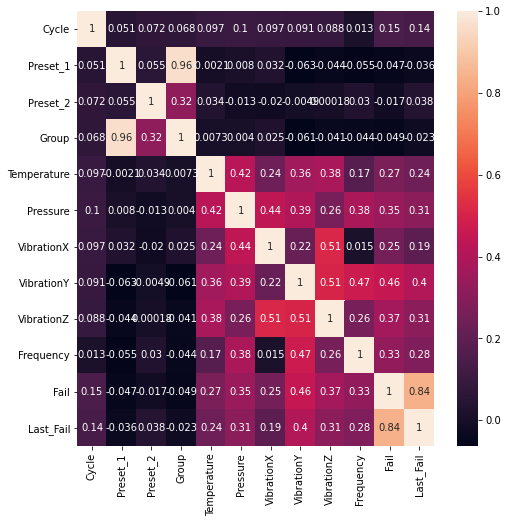

In [0]:
#Feature Selection
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(df.corr(),annot=True)
#display(fig)

In [0]:
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
values = enc.fit_transform(df[['Group']]).toarray()
names = enc.get_feature_names(['group'])
temp = pd.DataFrame(data=values, columns=names)

df = df.join(temp)

df['Last_Fail'] = df['Last_Fail'].astype('category')
df['Last_Fail'] = df['Last_Fail'].cat.codes

df = df.drop(['Last_Fail'],axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Group        800 non-null    int64  
 4   Temperature  800 non-null    float64
 5   Pressure     800 non-null    float64
 6   VibrationX   800 non-null    float64
 7   VibrationY   800 non-null    float64
 8   VibrationZ   800 non-null    float64
 9   Frequency    800 non-null    float64
 10  Fail         800 non-null    bool   
 11  group_11     800 non-null    float64
 12  group_12     800 non-null    float64
 13  group_13     800 non-null    float64
 14  group_14     800 non-null    float64
 15  group_15     800 non-null    float64
 16  group_16     800 non-null    float64
 17  group_17     800 non-null    float64
 18  group_18     800 non-null    float64
 19  group_21

In [0]:
train = df.copy()[df['Fail'] == False].drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1)
test = df.copy()[df['Fail'] == True].drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1)

valid = df.copy().drop(['Cycle','Preset_1','Preset_2','Group'],axis=1).loc[700:,:]

PCA:  [0.4055686  0.19075139]


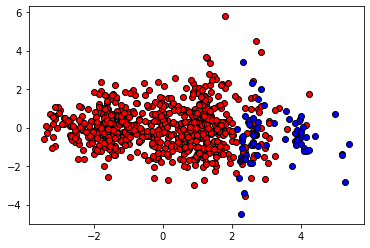

In [0]:
#Usando PCA para reduzir a dimensionalidade
pca = PCA(n_components=2)
scaler = preprocessing.StandardScaler()
train_norm = scaler.fit_transform(train.loc[:,'Temperature':'Frequency'])
test_norm = scaler.transform(test.loc[:,'Temperature':'Frequency'])
'''
train_norm = (train - train.mean())
print(train_norm.describe().round(2))
train_norm = (train_norm / train_norm.std())
print(train_norm.describe().round(2))

test_norm = (test - test.mean())
test_norm = (test_norm / test_norm.std())'''

pca.fit(train_norm)
print("PCA: ",pca.explained_variance_ratio_)
df_train_pandas = pca.fit_transform(train_norm)
df_new = pca.transform(test_norm)

train_pca = pd.DataFrame(df_train_pandas)
test_pca = pd.DataFrame(df_new)
#train_pca.plot.scatter(0,1)
#test_pca.plot.scatter(0,1)

plt.scatter(train_pca.loc[:, 0], train_pca.loc[:, 1],c='red', edgecolors='k')
plt.scatter(test_pca.loc[:, 0], test_pca.loc[:, 1],c='blue', edgecolors='k')

Isolation Forest

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


[[ 0  0]
 [38 28]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.42      0.60        66

    accuracy                           0.42        66
   macro avg       0.50      0.21      0.30        66
weighted avg       1.00      0.42      0.60        66



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


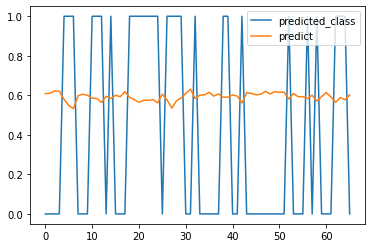

In [0]:
#variáveis
quantile = 0.95
seed = 12345
ntrees = 100

isf = IsolationForest(random_state=seed, contamination=(1-quantile),
                    n_estimators=ntrees, behaviour="new").fit(train)

iso_predictions = isf.predict(test)
iso_score = isf.score_samples(test)

sk_predictions = pd.DataFrame({
    "predicted_class": list(map(lambda x: 1*(x == -1), iso_predictions)),
    "predict": 1-(-iso_score)
})


y_real = test['Temperature'].apply(lambda x: 1 if 1 == 1 else 0)
y_pred = sk_predictions['predicted_class'].apply(lambda x: 1 if x >= 0.4 else 0)
c = confusion_matrix(y_real, y_pred)
print(c)
print(classification_report(y_real,y_pred))
sk_predictions.plot()

    predicted_class   predict
0                 0  0.397500
1                 0  0.394668
2                 0  0.379737
3                 0  0.393180
4                 0  0.381640
..              ...       ...
95                0  0.407710
96                1  0.435673
97                1  0.411170
98                1  0.422648
99                0  0.398410

[100 rows x 2 columns]
Acertos:  79.0  %
[[75  4]
 [15  6]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        79
           1       0.60      0.29      0.39        21

    accuracy                           0.81       100
   macro avg       0.72      0.62      0.64       100
weighted avg       0.78      0.81      0.78       100



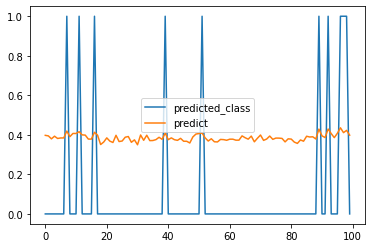

In [0]:
iso_predictions = isf.predict(valid.drop(['Fail'],axis=1))
iso_score = isf.score_samples(valid.drop(['Fail'],axis=1))

sk_predictions = pd.DataFrame({
    "predicted_class": list(map(lambda x: 1*(x == -1), iso_predictions)),
    "predict": (-iso_score)
})

print(sk_predictions)
valid['predict'] = sk_predictions['predicted_class']
#print(valid.info())
sk_predictions.plot()

def eval(row):
  if (row['predict'] == 1) and (row['Fail'] == True):
    return 1
  elif (row['predict'] == 1) and (row['Fail'] == False):
    return 0
  elif (row['predict'] != 1) and (row['Fail'] == False):
    return 1
  elif (row['predict'] != 1) and (row['Fail'] == True):
    return 0


valid['evaluation'] = valid.apply(lambda row: eval(row), axis=1)
print("Acertos: ", valid['evaluation'].sum() / len(valid['evaluation']) * 100 , ' %')

y_real = valid['Fail'].apply(lambda x: 1 if x == True else 0)
y_pred = sk_predictions['predicted_class'].apply(lambda x: 1 if x >= 0.5 else 0)
c = confusion_matrix(y_real, y_pred)
print(c)
print(classification_report(y_real,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


[[711  23]
 [ 49  17]]
              precision    recall  f1-score   support

       False       0.94      0.97      0.95       734
        True       0.42      0.26      0.32        66

    accuracy                           0.91       800
   macro avg       0.68      0.61      0.64       800
weighted avg       0.89      0.91      0.90       800



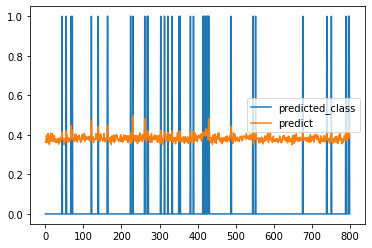

In [0]:
#teste no DF completo - unsupervised
X = df.copy().drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1)
iso_predictions = isf.fit_predict(X)
iso_score = isf.score_samples(X)

sk_predictions = pd.DataFrame({
    "predicted_class": list(map(lambda x: 1*(x == -1), iso_predictions)),
    "predict": (-iso_score)
})


y_real = df['Fail']
y_pred = sk_predictions['predicted_class'].apply(lambda x: 1 if x >= 0.4 else 0)
c = confusion_matrix(y_real, y_pred)
print(c)
print(classification_report(y_real,y_pred))
sk_predictions.plot()

LocalOutlierFactor

In [0]:
#detectando outliers locais nos dados normais
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(train)
X_scores = clf.negative_outlier_factor_

#removendo outliers usando LOF
df_train_out = pd.DataFrame(train)
y_pred = pd.DataFrame(y_pred)
df_train_out = train.merge(y_pred,left_index=True,right_index=True)
#df_train_outoff = df_train_out[df_train_out.0_y >0]
df_train_out

,Group,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,0
0,36,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,1
1,24,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,1
2,21,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,1
3,23,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,1
4,25,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,1
...,...,...,...,...,...,...,...,...
729,13,45.087587,49.426404,41.950298,39.764925,38.341162,61.667149,1
730,28,62.540023,72.011445,52.788667,55.054152,51.337362,82.979871,1
731,33,78.221491,79.197995,71.174173,74.290255,69.165221,124.394942,-1
732,22,37.485008,34.664224,39.984698,25.825999,26.089791,36.199718,1


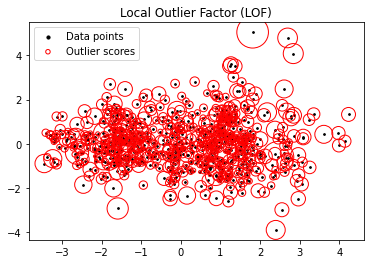

In [0]:
#PCA
plt.title("Local Outlier Factor (LOF)")
plt.scatter(df_train_pandas[:, 0], df_train_pandas[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(df_train_pandas[:, 0], df_train_pandas[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
#plt.axis('tight')
#plt.xlim((-5, 5))
#plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [0]:
# fit the model for novelty detection (novelty=True)
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(train)
y_pred_test = clf.predict(test)
y_pred_scores_test = clf.score_samples(test)

n_error_test = y_pred_test[y_pred_test == -1].size
print(n_error_test)
print(len(test))
print(n_error_test/ len(test) * 100 , ' %')


20
66
30.303030303030305  %


One SVM

In [0]:
#fit the model
#clf = svm.OneClassSVM(nu=0.261, gamma=0.05)
clf = svm.OneClassSVM()
clf.fit(train)

# DO NOT use predict, decision_function and score_samples on X_train as this
# would give wrong results but only on new unseen data (not used in X_train),
# e.g. X_test, X_outliers or the meshgrid
y_pred_test = clf.predict(test)
y_pred_scores_test = clf.score_samples(test)
y_pred_dfunc_out = clf.decision_function(test)
#print("pred:",y_pred_test)
print(y_pred_scores_test)

#print(y_pred_outliers)
n_error_test = y_pred_test[y_pred_test == -1].size
print(n_error_test)
print(len(test))
print(n_error_test/ len(test) * 100 , ' %')

[216.29082993 243.32148747 244.61790659 246.71265263 184.31258753
 127.13531824 115.54210038 238.08349009 242.16332308 240.56469981
 184.94344377 188.88315741 161.72710866 151.07673364 193.1191977
 226.18430863 179.75771811 225.72720269 175.27784999 192.44518794
 127.7673775  197.55253554 133.11215677 182.99146818 124.25632603
 245.54017539 152.85999754  89.08414428 167.54078929 179.86979626
 224.59482645 248.70307996 225.05806057 194.70751998 191.11599451
 233.7087384  194.26659486 187.53838098 190.78696138 218.52276268
 244.71447961 223.65987856 185.17675293 245.9212726  239.00653119
 238.98946883 231.40404441 232.45427679 239.49165277 231.53051119
 223.8522308  193.32369934 198.24956963 235.85945713 229.4591962
 205.52276682 178.45269892 169.3772666  195.85211439 196.21549837
 238.62086909 184.82523656 153.48153836 200.56489178 149.33274283
 226.71284448]
66
66
100.0  %


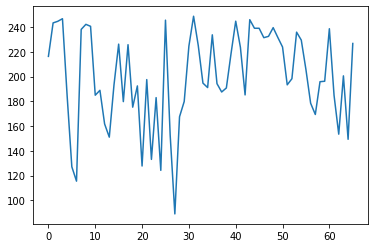

In [0]:
plt.plot(y_pred_scores_test)

     predict  Fail  predict_score
700       -1  True     238.989469
701       -1  True     231.404044
702       -1  True     232.454277
703       -1  True     239.491653
704       -1  True     231.530511
..       ...   ...            ...
795       -1  True     184.825237
796       -1  True     153.481538
797       -1  True     200.564892
798       -1  True     149.332743
799       -1  True     226.712844

[100 rows x 3 columns]
100
56.99999999999999  %
Acertos:  64.0  %
[[43 36]
 [ 0 21]]
              precision    recall  f1-score   support

           0       1.00      0.54      0.70        79
           1       0.37      1.00      0.54        21

    accuracy                           0.64       100
   macro avg       0.68      0.77      0.62       100
weighted avg       0.87      0.64      0.67       100



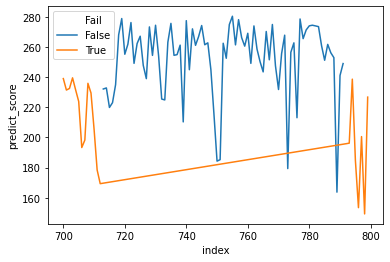

In [0]:
valid = df.copy().drop(['Cycle','Preset_1','Preset_2','Group'],axis=1).loc[700:,:]
y_pred_test = clf.predict(valid.drop(['Fail'],axis=1))
y_pred_scores_test = clf.score_samples(valid.drop(['Fail'],axis=1))
#print(y_pred_scores_test)
valid['predict'] = y_pred_test
valid['predict_score'] = y_pred_scores_test
print(valid[['predict','Fail','predict_score']])

n_error_test = y_pred_test[y_pred_test == -1].size

print(len(valid))
print(n_error_test/ len(valid) * 100 , ' %')
#plt.plot(y_pred_scores_test)
#valid[['predict_score','Fail']].plot()
sns.lineplot(x ='index',y="predict_score", data=valid.reset_index(), hue="Fail")

def eval(row):
  if (row['predict'] == -1) and (row['Fail'] == True):
    return 1
  elif (row['predict'] == -1) and (row['Fail'] == False):
    return 0
  elif (row['predict'] != -1) and (row['Fail'] == False):
    return 1
  elif (row['predict'] != -1) and (row['Fail'] == True):
    return 0


valid['evaluation'] = valid.apply(lambda row: eval(row), axis=1)
print("Acertos: ", valid['evaluation'].sum() / len(valid['evaluation']) * 100 , ' %')

y_real = valid['Fail'].apply(lambda x: 1 if x == True else 0)
y_pred = valid['predict'].apply(lambda x: 1 if x == -1 else 0)
c = confusion_matrix(y_real, y_pred)
print(c)
print(classification_report(y_real,y_pred))

[[367 367]
 [  0  66]]
              precision    recall  f1-score   support

       False       1.00      0.50      0.67       734
        True       0.15      1.00      0.26        66

    accuracy                           0.54       800
   macro avg       0.58      0.75      0.47       800
weighted avg       0.93      0.54      0.63       800



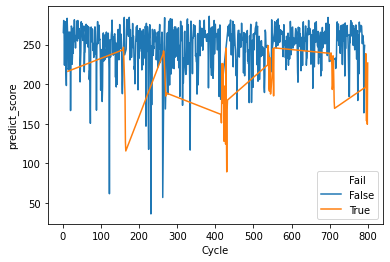

In [0]:
#teste no DF completo
X = df.copy().drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1)
iso_predictions = clf.predict(X)
iso_score = clf.score_samples(X)


y_real = df['Fail']
#y_pred = sk_predictions['predicted_class'].apply(lambda x: 1 if x >= 0.4 else 0)
y_pred = [1 if x == -1 else 0 for x in list(iso_predictions)]
c = confusion_matrix(y_real, y_pred)
print(c)
print(classification_report(y_real,y_pred))

data = df.copy().drop(['Preset_1','Preset_2','Group'],axis=1)
data["predict_score"] = iso_score
sns.lineplot(x ='Cycle',y="predict_score", data=data, hue="Fail")

Classification Models

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import sklearn.model_selection as skmodel


from scipy.stats import uniform, randint,relfreq

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
import matplotlib.pyplot as plt


In [0]:
#separar 70/30 treino e teste
#X = df.copy().loc[:,'Temperature':'Frequency']
#y = df.copy().loc[:,'Fail']

X = df.copy().drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1)
y = df.copy()['Fail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df.corr(),annot=True)
#display(fig)

In [0]:
def choose_model(X,y):
  models = []
  model_name = []
  model_score = []
  churns = []
  
  # random forest
  rndf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=0)
  rndf.fit(X, y)
  rndf_score = rndf.score(X,y)
  models.append(rndf)
  model_score.append(rndf_score)
  y_pred = rndf.predict(X)
  c = confusion_matrix(y, y_pred)
  churns.append(c[1,1])
  model_name.append('Random Forest')
  
  
  # logistic regression
  log_clf = LogisticRegression(random_state=0).fit(X, y)
  log_clf_score = log_clf.score(X,y)
  models.append(log_clf)
  model_score.append(log_clf_score)
  y_pred = log_clf.predict(X)
  c = confusion_matrix(y, y_pred)
  churns.append(c[1,1])
  model_name.append('Logistic Regression')
  
  # xgboost
  xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
  xgb_model.fit(X, y)
  xgb_score = xgb_model.score(X,y)
  models.append(xgb_model)
  model_score.append(xgb_score)
  y_pred = xgb_model.predict(X)
  c = confusion_matrix(y, y_pred)
  churns.append(c[1,1])
  model_name.append('XGBoost')
  
  aval = pd.DataFrame({'model':model_name, 'score':model_score, 'churns_pred':churns})
  aval['model_full_score'] = aval.score * aval.churns_pred
  #aval['model_full_score'] = aval.score
  
  rank = aval['model_full_score'].tolist()
  final_model_idx = rank.index(max(rank))
  final_model = models[final_model_idx]
   
  
  return aval,final_model

In [0]:
#desempenho do modelo no treino
train_df = X_train

aval, model = choose_model(train_df,y_train)
print(aval)

                 model     score  churns_pred  model_full_score
0        Random Forest  0.967857           33         31.939286
1  Logistic Regression  0.944643           31         29.283929
2              XGBoost  0.996429           50         49.821429


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
#desempenho do modelo no treino
test_df = X_train
y_pred = model.predict(test_df)
c = confusion_matrix(y_train, y_pred)
score = model.score(test_df,y_train)

best_model_prob = model.predict_proba(test_df)

print("Score: ",score)
print(c)
print(classification_report(y_train,y_pred))

Score:  0.9964285714285714
[[508   1]
 [  1  50]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       509
        True       0.98      0.98      0.98        51

    accuracy                           1.00       560
   macro avg       0.99      0.99      0.99       560
weighted avg       1.00      1.00      1.00       560



In [0]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
f = 'gain'
model.get_booster().get_score(importance_type= f)

{'Frequency': 2.316223552151484,
 'Pressure': 2.0677995077333327,
 'Temperature': 2.515288882207208,
 'VibrationX': 1.5006080049941177,
 'VibrationY': 4.512062916835444,
 'VibrationZ': 2.683911643734147,
 'group_12': 0.511202753,
 'group_18': 0.453208923}

In [0]:
#desempenho do modelo no teste
test_df = X_test
y_pred = model.predict(test_df)
c = confusion_matrix(y_test, y_pred)
score = model.score(test_df,y_test)

best_model_prob = model.predict_proba(test_df)
#best_model_pred = model.predict(test_df)

#data_test['best_model_prob'] = model.predict_proba(test_df)[:,1]
#data_test['best_model_pred'] = model.predict(test_df)


print("Score: ",score)
print(c)
print(classification_report(y_test,y_pred))

Score:  0.9541666666666667
[[220   5]
 [  6   9]]
              precision    recall  f1-score   support

       False       0.97      0.98      0.98       225
        True       0.64      0.60      0.62        15

    accuracy                           0.95       240
   macro avg       0.81      0.79      0.80       240
weighted avg       0.95      0.95      0.95       240



Usando SMOTE

In [0]:
from imblearn.over_sampling import SMOTE

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
#sm = SMOTE(sampling_strategy='minority', random_state=7)
sm = SMOTE(sampling_strategy='auto', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_sample(train_df, y_train)
#oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
#oversampled_train.columns = normalized_df.columns
rndf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=0)
rndf.fit(oversampled_trainX, oversampled_trainY)
rndf_score = rndf.score(oversampled_trainX, oversampled_trainY)
print(rndf_score)

y_pred = rndf.predict(oversampled_trainX)
c = confusion_matrix(oversampled_trainY, y_pred)
print(c)
print(classification_report(oversampled_trainY,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9793713163064833
[[488  21]
 [  0 509]]
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       509
        True       0.96      1.00      0.98       509

    accuracy                           0.98      1018
   macro avg       0.98      0.98      0.98      1018
weighted avg       0.98      0.98      0.98      1018



In [0]:
# SMOTE + best model
columns = train_df.columns
oversampled_trainX = pd.DataFrame(data = oversampled_trainX ,columns = columns)
model.fit(oversampled_trainX, oversampled_trainY)
model_score = model.score(oversampled_trainX, oversampled_trainY)
print(model_score)

y_pred = model.predict(oversampled_trainX)
c = confusion_matrix(oversampled_trainY, y_pred)
print(c)
print(classification_report(oversampled_trainY,y_pred))

0.9941060903732809
[[503   6]
 [  0 509]]
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       509
        True       0.99      1.00      0.99       509

    accuracy                           0.99      1018
   macro avg       0.99      0.99      0.99      1018
weighted avg       0.99      0.99      0.99      1018



In [0]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
f = 'gain'
model.get_booster().get_score(importance_type= f)

{'Frequency': 8.825540474127905,
 'Pressure': 5.362629268470589,
 'Temperature': 28.225746073030308,
 'VibrationX': 6.292729521218178,
 'VibrationY': 17.480713962209876,
 'VibrationZ': 31.47462377731667,
 'group_11': 1.73527479,
 'group_12': 3.334566668250002,
 'group_14': 3.8256614200000003,
 'group_16': 2.2187713007272722,
 'group_17': 5.71720028,
 'group_18': 0.860291719,
 'group_21': 2.2619603500000003,
 'group_23': 1.3212803556666668,
 'group_25': 4.494142055,
 'group_28': 1.726483709375,
 'group_31': 1.670369403,
 'group_33': 6.849833158,
 'group_35': 3.1516426645000006,
 'group_36': 2.718307582272727}

0.9458333333333333
[[216   9]
 [  4  11]]
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       225
        True       0.55      0.73      0.63        15

    accuracy                           0.95       240
   macro avg       0.77      0.85      0.80       240
weighted avg       0.95      0.95      0.95       240



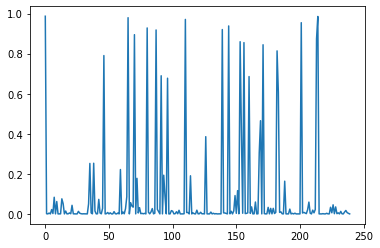

In [0]:
y_pred = model.predict(test_df)
model_score = model.score(test_df, y_test)
c = confusion_matrix(y_test, y_pred)
print(model_score)
print(c)
print(classification_report(y_test,y_pred))

best_model_prob = model.predict_proba(test_df)[:,1]
plt.plot(best_model_prob)

0.97625
[[719  15]
 [  4  62]]
              precision    recall  f1-score   support

       False       0.99      0.98      0.99       734
        True       0.81      0.94      0.87        66

    accuracy                           0.98       800
   macro avg       0.90      0.96      0.93       800
weighted avg       0.98      0.98      0.98       800



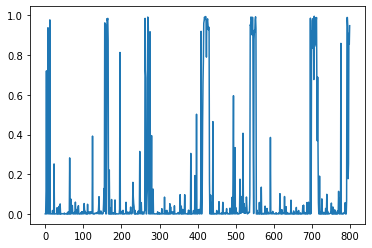

In [0]:
#testar no dataset completo
y_pred = model.predict(df.copy().drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1))
y_test_df = df.loc[:,'Fail']
model_score = model.score(df.copy().drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1), y_test_df)
c = confusion_matrix(y_test_df, y_pred)
print(model_score)
print(c)
print(classification_report(y_test_df,y_pred))

best_model_prob = model.predict_proba(df.copy().drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1))[:,1]
plt.plot(best_model_prob)

In [0]:
#undersampling
from imblearn.under_sampling import CondensedNearestNeighbour

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = CondensedNearestNeighbour()

# Fit the model to generate the data.
undersampled_trainX, undersampled_trainY = sm.fit_sample(train_df, y_train)
#oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
#oversampled_train.columns = normalized_df.columns
rndf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=0)
rndf.fit(undersampled_trainX, undersampled_trainY)
rndf_score = rndf.score(undersampled_trainX, undersampled_trainY)
print(rndf_score)

y_pred = rndf.predict(undersampled_trainX)
c = confusion_matrix(undersampled_trainY, y_pred)
print(c)
print(classification_report(undersampled_trainY,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

0.968421052631579
[[41  3]
 [ 0 51]]
              precision    recall  f1-score   support

       False       1.00      0.93      0.96        44
        True       0.94      1.00      0.97        51

    accuracy                           0.97        95
   macro avg       0.97      0.97      0.97        95
weighted avg       0.97      0.97      0.97        95



In [0]:
# undersampled + best model
columns = train_df.columns
undersampled_trainX = pd.DataFrame(data = undersampled_trainX ,columns = columns)
model.fit(undersampled_trainX, undersampled_trainY)
model_score = model.score(undersampled_trainX, undersampled_trainY)
print(model_score)

y_pred = model.predict(undersampled_trainX)
c = confusion_matrix(undersampled_trainY, y_pred)
print(c)
print(classification_report(undersampled_trainY,y_pred))

0.9894736842105263
[[43  1]
 [ 0 51]]
              precision    recall  f1-score   support

       False       1.00      0.98      0.99        44
        True       0.98      1.00      0.99        51

    accuracy                           0.99        95
   macro avg       0.99      0.99      0.99        95
weighted avg       0.99      0.99      0.99        95



In [0]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
f = 'gain'
model.get_booster().get_score(importance_type= f)

{'Frequency': 1.1987156682122642,
 'Pressure': 0.9331994665018181,
 'Temperature': 1.5586366950533335,
 'VibrationX': 1.0126060304363633,
 'VibrationY': 1.580963969567213,
 'VibrationZ': 1.1976257938560977}

In [0]:
y_pred = model.predict(test_df)
print(len(test_df),len(y_test))
model_score = model.score(test_df, y_test)
c = confusion_matrix(y_test, y_pred)
print(model_score)
print(c)
print(classification_report(y_test,y_pred))

240 240
0.9375
[[212  13]
 [  2  13]]
              precision    recall  f1-score   support

       False       0.99      0.94      0.97       225
        True       0.50      0.87      0.63        15

    accuracy                           0.94       240
   macro avg       0.75      0.90      0.80       240
weighted avg       0.96      0.94      0.95       240



0.96375
[[707  27]
 [  2  64]]
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       734
        True       0.70      0.97      0.82        66

    accuracy                           0.96       800
   macro avg       0.85      0.97      0.90       800
weighted avg       0.97      0.96      0.97       800



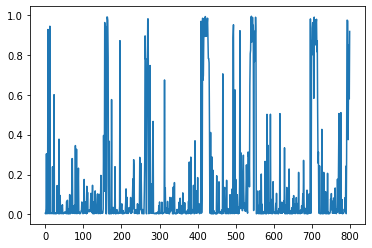

In [0]:
#testar no dataset completo
y_pred = model.predict(df.copy().drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1))
y_test_df = df.loc[:,'Fail']
model_score = model.score(df.copy().drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1), y_test_df)
c = confusion_matrix(y_test_df, y_pred)
print(model_score)
print(c)
print(classification_report(y_test_df,y_pred))

best_model_prob = model.predict_proba(df.copy().drop(['Fail','Cycle','Preset_1','Preset_2','Group'],axis=1))[:,1]
plt.plot(best_model_prob)